In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_palette(sns.color_palette('Set2')[::2])
sns.set_context('paper', font_scale=1.5)

from scipy.stats import ttest_rel, ttest_ind, skew
import numpy as np
import os
import yaml
import shutil
from collections import OrderedDict

#from deep_experiments.utils import load_experiment_dirs, quick_load_experiments_tsv, get_significance_by_column 
#from utils import add_stats, load_morph_probing_dirs, load_probing_dirs
import pickle
import yaml

#from transformers import AutoTokenizer

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Data loading

In [2]:
morph = pd.read_table("../results/morphology.tsv")
pos = pd.read_table("../results/pos.tsv")
ner = pd.read_table("../results/ner.tsv")
morph_all_layers = pd.read_table("../results/morphology_all_layers.tsv")
pos_all_layers = pd.read_table("../results/pos_all_layers.tsv")
ner_all_layers = pd.read_table("../results/ner_all_layers.tsv")

In [3]:
morph['full_task'] = morph['language'] + ' ' + morph['task']
morph_all_layers['full_task'] = morph_all_layers['language'] + ' ' + morph_all_layers['task']

In [4]:
pos.layer_pooling.value_counts()

6    482
Name: layer_pooling, dtype: int64

In [5]:
pos.groupby(['language', 'subword_pooling', 'model']).size().unstack(1)

subword_pooling                        attn  avg  f+l  first  last  last2  \
language model                                                              
Arabic   bert-base-multilingual-cased     3    3    3      3     3      3   
         xlm-roberta-base                 3    3    3      3     3      3   
Chinese  bert-base-multilingual-cased     3    3    3      3     3      3   
         xlm-roberta-base                 3    3    3      3     3      3   
Czech    bert-base-multilingual-cased     3    3    3      3     3      3   
         xlm-roberta-base                 2    3    3      3     3      3   
English  bert-base-multilingual-cased     3    3    3      3     3      3   
         xlm-roberta-base                 3    3    3      3     3      3   
Finnish  bert-base-multilingual-cased     3    3    3      3     3      3   
         xlm-roberta-base                 3    3    3      3     3      3   
French   bert-base-multilingual-cased     3    3    3      3     3      3   
         xlm-roberta-base                 2    3    3      3     3      3   
German   bert-base-multilingual-cased     3    3    3      3     3      3   
         xlm-roberta-base                 2    3    3      3     3      3   
Japanese bert-base-multilingual-cased     3    3    3      3     3      3   
         xlm-roberta-base                 3    3    3      3     3      3   
Korean   bert-base-multilingual-cased     3    3    3      3     3      3   
         xlm-roberta-base                 2    3    3      3     3      3   

subword_pooling                        lstm  max  sum  
language model                                         
Arabic   bert-base-multilingual-cased     3    3    3  
         xlm-roberta-base                 3    3    3  
Chinese  bert-base-multilingual-cased     3    3    3  
         xlm-roberta-base                 3    3    3  
Czech    bert-base-multilingual-cased     3    3    3  
         xlm-roberta-base                 3    3    3  
English  bert-base-multilingual-cased     3    3    3  
         xlm-roberta-base                 3    3    3  
Finnish  bert-base-multilingual-cased     3    3    3  
         xlm-roberta-base                 3    3    3  
French   bert-base-multilingual-cased     3    3    3  
         xlm-roberta-base                 3    3    3  
German   bert-base-multilingual-cased     3    3    3  
         xlm-roberta-base                 3    3    3  
Japanese bert-base-multilingual-cased     3    3    3  
         xlm-roberta-base                 3    3    3  
Korean   bert-base-multilingual-cased     3    3    3  
         xlm-roberta-base                 3    3    3

# Layer choice

/home/judit/permanent/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/judit/permanent/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/judit/permanent/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

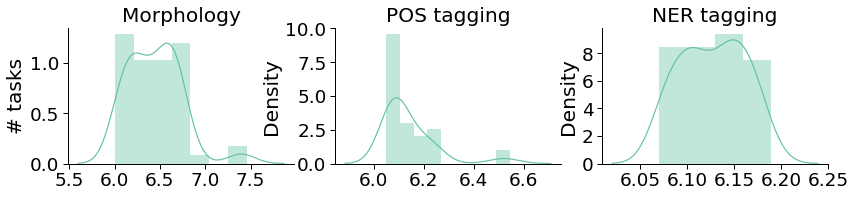

In [6]:
def get_layer_weighted_average(df):
    df = df[df.layer_pooling != 'sum']
    dev_sum = df.dev_acc.sum()
    return (df.dev_acc * df.layer_pooling.astype(int)).sum() / dev_sum
    
morph_layers = morph_all_layers.groupby(['model', 'language', 'task', 'subword_pooling']).apply(get_layer_weighted_average)
pos_layers = pos_all_layers.groupby(['model', 'language', 'subword_pooling']).apply(get_layer_weighted_average)
ner_layers = ner_all_layers.groupby(['model', 'language', 'subword_pooling']).apply(get_layer_weighted_average)

with sns.plotting_context('paper', font_scale=2.1):
    fig, ax = plt.subplots(1, 3, figsize=(12, 2.5))

    sns.distplot(morph_layers, ax=ax[0])
    # ax[0].set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax[0].get_xticklabels()])
    sns.distplot(pos_layers, ax=ax[1])
    sns.distplot(ner_layers, ax=ax[2])
    ax[0].set_ylabel("# tasks")

    ax[0].set_title("Morphology")
    ax[1].set_title("POS tagging")
    ax[2].set_title("NER tagging")
    plt.subplots_adjust(wspace=.18, left=0.08, right=0.96)
    sns.despine()
    #fig.savefig("../fig/dist_layer_average.pdf")
    fig.savefig("../fig/dist_layer_average.png", dpi=300)

# Standard deviations

Each combination is run 3 times. The standard deviation of the 3 runs is very small.

In [7]:
(morph.groupby(['full_task', 'model', 'subword_pooling']).test_acc.std() < 0.05).value_counts()

True     251
False      1
Name: test_acc, dtype: int64

In [8]:
pos.groupby(['language', 'model', 'layer_pooling', 'subword_pooling']).test_acc.std().describe()

count    162.000000
mean       0.000710
std        0.000503
min        0.000056
25%        0.000364
50%        0.000610
75%        0.000865
max        0.002866
Name: test_acc, dtype: float64

In [9]:
ner.groupby(['language', 'model', 'layer_pooling', 'subword_pooling']).test_acc.std().describe()

count    162.000000
mean       0.001049
std        0.000608
min        0.000090
25%        0.000644
50%        0.000976
75%        0.001373
max        0.003510
Name: test_acc, dtype: float64

# first-last gap as a function of layers

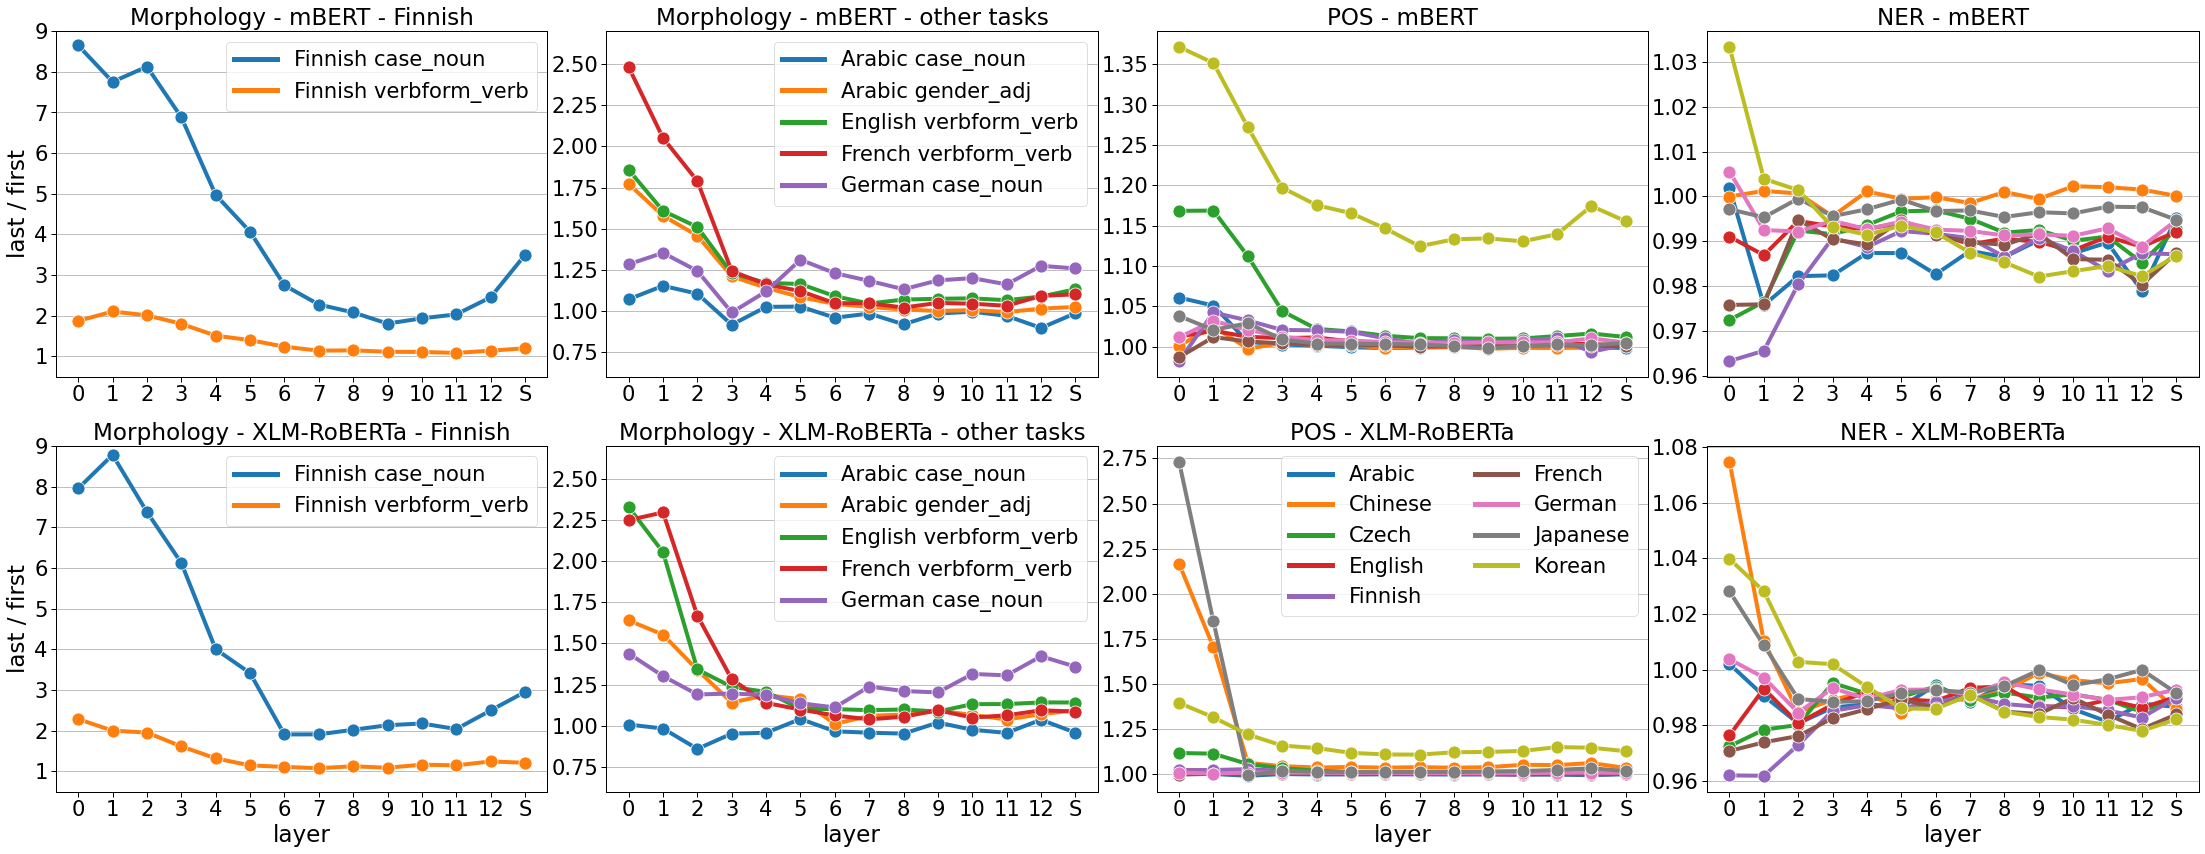

In [10]:
import copy
keep = ['Arabic case_noun', 'Arabic gender_adj', 'English verbform_verb', 'French verbform_verb', 'German case_noun']
m = morph_all_layers[
    (morph_all_layers.subword_pooling.isin(['first', 'last']))
].copy()
m.layer_pooling = m.layer_pooling.replace('sum', 'S').astype(str)
layers = [str(l) for l in range(13)] + ['S']
m = m.groupby(['full_task', 'model', 'layer_pooling', 'subword_pooling']).test_acc.mean().unstack()
m['last/first'] = m['last'] / m['first']
m = m.reset_index()
m.layer_pooling = pd.Categorical(m.layer_pooling, ordered=True, categories=layers)

def setup_ax(ax, legend_kws={}):
    ax.set_ylabel("")
    ax.set_xlabel("")
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        handles = [copy.copy(ha) for ha in handles]
        [ha.set_linewidth(5) for ha in handles ]
        leg = ax.legend(handles=handles, labels=labels, **legend_kws)
    ax.grid(True, axis='y')
    
lineargs = dict(marker='o', markersize=13, linewidth=4, palette='tab10')
with sns.plotting_context('paper', font_scale=2.4):
    fig, ax = plt.subplots(2, 4, figsize=(32, 12))

    d = m[(m.model.str.startswith('bert')) & (m.full_task.str.startswith('Finnish'))]
    sns.lineplot(x=d.layer_pooling, y=d['last/first'], hue=d.full_task, ax=ax[0, 0], legend='full', **lineargs)
    ax[0, 0].set_ylim(.5, 9)

    d = m[(m.model.str.startswith('bert')==False) & (m.full_task.str.startswith('Finnish'))]
    sns.lineplot(x=d.layer_pooling, y=d['last/first'], hue=d.full_task, ax=ax[1, 0], **lineargs)
    ax[1, 0].set_ylim(.5, 9)

    d = m[(m.model.str.startswith('bert')) & (m.full_task.isin(keep))]
    sns.lineplot(x=d.layer_pooling, y=d['last/first'], hue=d.full_task, legend='brief', ax=ax[0, 1], **lineargs)
    ax[0, 1].set_ylim(0.6, 2.7)

    d = m[(m.model.str.startswith('bert')==False) & (m.full_task.isin(keep))]
    sns.lineplot(x=d.layer_pooling, y=d['last/first'], hue=d.full_task, legend='full', ax=ax[1, 1], **lineargs)
    ax[1, 1].set_ylim(0.6, 2.7)
    
    # POS
    p = pos_all_layers[(pos_all_layers.train_size==2000) & (pos_all_layers.subword_pooling.isin(['first', 'last']))].copy()
    p.layer_pooling = p.layer_pooling.replace('sum', 'S').astype(str)
    p = p.groupby(['language', 'model', 'layer_pooling', 'subword_pooling']).test_acc.mean().unstack()
    p['last/first'] = p['last'] / p['first']
    p = p.reset_index()
    p.layer_pooling = pd.Categorical(p.layer_pooling, ordered=True, categories=layers)

    d = p[(p.model.str.startswith('bert'))]
    sns.lineplot(x=d.layer_pooling, y=d['last/first'], hue=d.language, ax=ax[0, 2], legend=False,**lineargs)

    d = p[(p.model.str.startswith('bert')==False)]
    sns.lineplot(x=d.layer_pooling, y=d['last/first'], hue=d.language, ax=ax[1, 2], **lineargs)

    # NER
    n = ner_all_layers[(ner_all_layers.subword_pooling.isin(['first', 'last']))].copy()
    n.layer_pooling = n.layer_pooling.replace('sum', 'S').astype(str)
    n = n.groupby(['language', 'model', 'layer_pooling', 'subword_pooling']).test_acc.mean().unstack()
    n['last/first'] = n['last'] / n['first']
    n = n.reset_index()
    n.layer_pooling = pd.Categorical(n.layer_pooling, ordered=True, categories=layers)

    d = n[(n.model.str.startswith('bert'))]
    sns.lineplot(x=d.layer_pooling, y=d['last/first'], hue=d.language, ax=ax[0, 3], legend=False,**lineargs)

    d = n[(n.model.str.startswith('bert')==False)]
    sns.lineplot(x=d.layer_pooling, y=d['last/first'], hue=d.language, ax=ax[1, 3], legend=False, **lineargs)

    # axis setup
    for ai, a in enumerate(ax.flat):
        if ai == 6:
            setup_ax(a, legend_kws={'ncol': 2})
        else:
            setup_ax(a)

    # Text
    ax[0, 0].set_title("Morphology - mBERT - Finnish")
    ax[1, 0].set_title("Morphology - XLM-RoBERTa - Finnish")
    ax[0, 1].set_title("Morphology - mBERT - other tasks")
    ax[1, 1].set_title("Morphology - XLM-RoBERTa - other tasks")
    ax[0, 2].set_title("POS - mBERT")
    ax[1, 2].set_title("POS - XLM-RoBERTa")
    ax[0, 3].set_title("NER - mBERT")
    ax[1, 3].set_title("NER - XLM-RoBERTa")
    ax[1, 0].set_xlabel("layer")
    ax[1, 1].set_xlabel("layer")
    ax[1, 2].set_xlabel("layer")
    ax[1, 3].set_xlabel("layer")
    ax[0, 0].set_ylabel("last / first")
    ax[1, 0].set_ylabel("last / first")
    plt.subplots_adjust(left=0.05, bottom=0.07, right=0.98, top=0.95, wspace=.12)

    #fig.savefig("../fig/line_last_first_ratio.pdf")
    fig.savefig("../fig/line_last_first_ratio.png", dpi=600)

## Same with nominal values for LAST

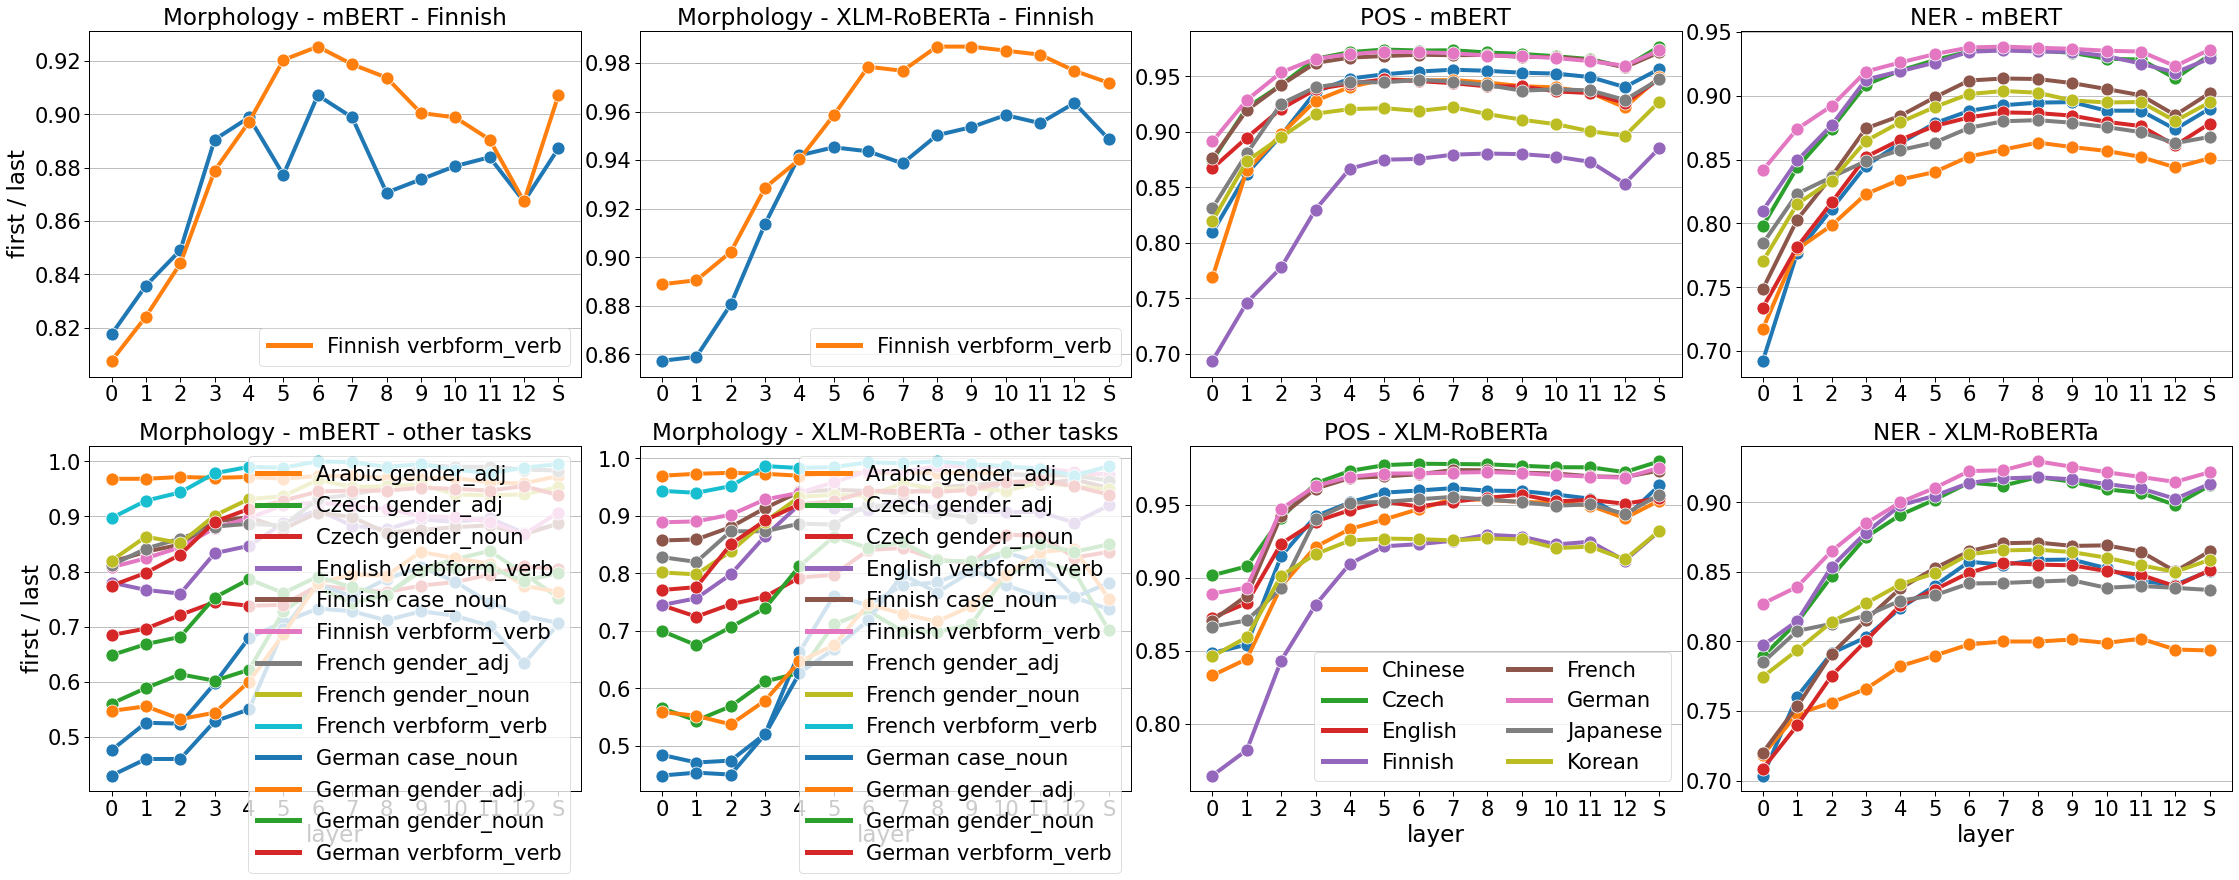

In [11]:
def setup_ax(ax, legend_kws={}):
    ax.set_ylabel("")
    ax.set_xlabel("")
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        handles = [copy.copy(ha) for ha in handles[1:] ]
        [ha.set_linewidth(5) for ha in handles ]
        leg = ax.legend(handles=handles, labels=labels[1:], **legend_kws)
    ax.grid(True, axis='y')
    
lineargs = dict(marker='o', markersize=13, linewidth=4, palette='tab10')
with sns.plotting_context('paper', font_scale=2.4):
    fig, ax = plt.subplots(2, 4, figsize=(32, 12))

    d = m[(m.model.str.startswith('bert')) & (m.full_task.str.startswith('Finnish'))]
    sns.lineplot(x=d.layer_pooling, y=d['last'], hue=d.full_task, ax=ax[0, 0], **lineargs)
    #ax[0, 0].set_ylim(.5, 9)

    d = m[(m.model.str.startswith('bert')==False) & (m.full_task.str.startswith('Finnish'))]
    sns.lineplot(x=d.layer_pooling, y=d['last'], hue=d.full_task, ax=ax[0, 1], **lineargs)
    #ax[0, 1].set_ylim(.5, 9)

    d = m[(m.model.str.startswith('bert'))]
    sns.lineplot(x=d.layer_pooling, y=d['last'], hue=d.full_task, legend='brief', ax=ax[1, 0], **lineargs)
    #ax[1, 0].set_ylim(0.6, 2.7)

    d = m[(m.model.str.startswith('bert')==False)]
    sns.lineplot(x=d.layer_pooling, y=d['last'], hue=d.full_task, legend='full', ax=ax[1, 1], **lineargs)
    #ax[1, 1].set_ylim(0.6, 2.7)
    
    # POS
    p = pos_all_layers[(pos_all_layers.train_size==2000) & (pos_all_layers.subword_pooling.isin(['first', 'last']))].copy()
    p.layer_pooling = p.layer_pooling.replace('sum', 'S').astype(str)
    p = p.groupby(['language', 'model', 'layer_pooling', 'subword_pooling']).test_acc.mean().unstack()
    p['last/first'] = p['last'] / p['first']
    p = p.reset_index()
    p.layer_pooling = pd.Categorical(p.layer_pooling, ordered=True, categories=layers)

    d = p[(p.model.str.startswith('bert'))]
    sns.lineplot(x=d.layer_pooling, y=d['last'], hue=d.language, ax=ax[0, 2], legend=False,**lineargs)

    d = p[(p.model.str.startswith('bert')==False)]
    sns.lineplot(x=d.layer_pooling, y=d['last'], hue=d.language, ax=ax[1, 2], **lineargs)

    # NER
    n = ner_all_layers[(ner_all_layers.subword_pooling.isin(['first', 'last']))].copy()
    n.layer_pooling = n.layer_pooling.replace('sum', 'S').astype(str)
    n = n.groupby(['language', 'model', 'layer_pooling', 'subword_pooling']).test_acc.mean().unstack()
    n['last/first'] = n['last'] / n['first']
    n = n.reset_index()
    n.layer_pooling = pd.Categorical(n.layer_pooling, ordered=True, categories=layers)

    d = n[(n.model.str.startswith('bert'))]
    sns.lineplot(x=d.layer_pooling, y=d['last'], hue=d.language, ax=ax[0, 3], legend=False,**lineargs)

    d = n[(n.model.str.startswith('bert')==False)]
    sns.lineplot(x=d.layer_pooling, y=d['last'], hue=d.language, ax=ax[1, 3], legend=False, **lineargs)

    # axis setup
    for ai, a in enumerate(ax.flat):
        if ai == 6:
            setup_ax(a, legend_kws={'ncol': 2})
        else:
            setup_ax(a)

    # Text
    ax[0, 0].set_title("Morphology - mBERT - Finnish")
    ax[0, 1].set_title("Morphology - XLM-RoBERTa - Finnish")
    ax[1, 0].set_title("Morphology - mBERT - other tasks")
    ax[1, 1].set_title("Morphology - XLM-RoBERTa - other tasks")
    ax[1, 0].set_xlabel("layer")
    ax[1, 1].set_xlabel("layer")
    ax[0, 2].set_title("POS - mBERT")
    ax[1, 2].set_title("POS - XLM-RoBERTa")
    ax[0, 3].set_title("NER - mBERT")
    ax[1, 3].set_title("NER - XLM-RoBERTa")
    ax[1, 0].set_xlabel("layer")
    ax[1, 1].set_xlabel("layer")
    ax[1, 2].set_xlabel("layer")
    ax[1, 3].set_xlabel("layer")
    ax[0, 0].set_ylabel("first / last")
    ax[1, 0].set_ylabel("first / last")
    plt.subplots_adjust(left=0.05, bottom=0.07, right=0.98, top=0.95, wspace=.12)

    #fig.savefig("fig/line_last_first_ratio.pdf")

# Save full result tables as LaTeX tables

In [12]:
m = morph.groupby(['full_task', 'model', 'subword_pooling']).test_acc.mean().unstack().round(3) * 100
subw = ['first', 'last', 'last2', 'f+l', 'sum', 'max', 'avg', 'attn', 'lstm']
m = m[subw]
maxes = m.max(axis=1)

m = m.reset_index()
m.model = m.model.str.replace('bert-base-multilingual-cased', 'mBERT')
m.model = m.model.str.replace('xlm-roberta-base', 'XLM-Ro')
m

subword_pooling,full_task,model,first,last,last2,f+l,sum,max,avg,attn,lstm
0,Arabic case_noun,mBERT,76.5,73.3,74.0,74.8,75.0,73.5,75.0,75.5,74.8
1,Arabic case_noun,XLM-Ro,77.1,74.5,74.0,75.6,80.9,80.1,79.3,77.8,74.5
2,Arabic gender_adj,mBERT,93.3,97.3,97.0,97.5,98.8,98.2,98.2,99.3,97.3
3,Arabic gender_adj,XLM-Ro,96.5,97.5,97.2,97.5,99.0,99.0,99.0,99.5,97.5
4,Czech gender_adj,mBERT,41.5,77.1,74.0,72.6,64.2,63.0,63.0,75.6,68.0
5,Czech gender_adj,XLM-Ro,41.6,73.5,71.8,70.8,64.2,65.0,63.2,73.0,66.5
6,Czech gender_noun,mBERT,61.7,77.4,77.9,74.6,76.3,75.1,74.8,81.3,79.3
7,Czech gender_noun,XLM-Ro,69.3,84.1,83.3,83.7,80.6,82.4,81.1,82.9,82.4
8,English verbform_verb,mBERT,83.7,91.2,87.2,89.2,89.0,89.5,89.7,90.7,88.5
9,English verbform_verb,XLM-Ro,82.7,91.0,89.7,90.8,91.8,91.7,89.0,91.3,89.7


In [13]:
def highlight_max(row):
    mval = row[subw].max()
    for k in subw:
        if row[k] == mval:
            row[k] = 'BBB{:.1f}CCC'.format(mval)
    return row

def normalize_taskname(full_task):
    lang, t = full_task.split(" ")
    tag, pos = t.split("_")
    return "LLL{}, {}, {}RRR".format(lang, tag.title(), pos.upper())
    
def format_colname(col):
    if col in subw:
        return f"\\textsc{{{col}}}"
    return f"\\textbf{{{col}}}"

m['task'] = m.full_task.apply(normalize_taskname)
m = m.drop('full_task', axis=1)
m = m[['task', 'model'] + subw]
m = m.apply(highlight_max, axis=1)
m.columns = m.columns.map(format_colname)
txt = m.to_latex(index=False, escape=False)
txt = txt.replace("LLL", "$\\langle$")
txt = txt.replace("RRR", "$\\rangle$")
txt = txt.replace("BBB", "\\textbf{")
txt = txt.replace("CCC", "}")
with open("../fig/table_all_morph.tex", "w") as f:
    f.write(txt)

In [14]:
p = pos.groupby(['language', 'model', 'subword_pooling']).test_acc.mean().unstack().round(3) * 100
p = p.reset_index()
p.model = p.model.str.replace('bert-base-multilingual-cased', 'mBERT')
p.model = p.model.str.replace('xlm-roberta-base', 'XLM-RoBERTa')
p

subword_pooling,language,model,attn,avg,f+l,first,last,last2,lstm,max,sum
0,Arabic,mBERT,96.1,96.4,96.4,96.1,96.2,96.3,96.5,96.4,96.4
1,Arabic,XLM-RoBERTa,96.5,96.8,96.8,96.6,96.6,96.7,96.8,96.7,96.8
2,Chinese,mBERT,95.5,96.2,96.2,95.3,95.3,96.2,96.2,96.1,96.1
3,Chinese,XLM-RoBERTa,94.9,95.3,95.4,92.6,95.3,95.4,95.4,95.1,95.4
4,Czech,mBERT,98.2,98.2,98.3,97.5,98.2,98.3,98.3,98.2,98.1
5,Czech,XLM-RoBERTa,98.4,98.4,98.4,98.0,98.3,98.4,98.5,98.3,98.4
6,English,mBERT,95.8,96.0,96.0,95.5,95.7,95.8,96.0,95.8,95.7
7,English,XLM-RoBERTa,96.1,96.3,96.2,95.9,96.1,96.3,96.4,96.3,96.2
8,Finnish,mBERT,90.9,91.4,91.1,90.1,90.2,91.6,92.3,91.2,91.2
9,Finnish,XLM-RoBERTa,94.8,95.0,95.0,94.3,94.1,94.9,95.3,94.9,95.0


In [15]:
p = p.apply(highlight_max, axis=1)
p.columns = p.columns.map(format_colname)

txt = p.to_latex(index=False, escape=False)
txt = txt.replace("BBB", "\\textbf{")
txt = txt.replace("CCC", "}")
with open("../fig/table_all_pos.tex", "w") as f:
    f.write(txt)

In [16]:
n = ner.groupby(['language', 'model', 'subword_pooling']).test_acc.mean().unstack().round(3) * 100
n = n.reset_index()
n.model = n.model.str.replace('bert-base-multilingual-cased', 'mBERT')
n.model = n.model.str.replace('xlm-roberta-base', 'XLM-RoBERTa')
n

subword_pooling,language,model,attn,avg,f+l,first,last,last2,lstm,max,sum
0,Arabic,mBERT,92.0,92.6,92.8,92.4,91.9,91.9,92.7,92.1,92.4
1,Arabic,XLM-RoBERTa,88.6,89.8,89.7,89.1,88.7,89.0,90.0,89.2,89.5
2,Chinese,mBERT,87.0,87.0,87.0,87.0,86.9,87.1,86.8,87.1,87.2
3,Chinese,XLM-RoBERTa,82.2,83.1,83.1,82.5,82.3,83.1,83.6,82.3,83.0
4,Czech,mBERT,95.3,95.5,95.6,95.3,95.0,95.3,95.5,95.4,95.4
5,Czech,XLM-RoBERTa,93.6,94.2,94.3,93.9,93.5,93.9,94.2,93.9,94.0
6,English,mBERT,90.8,91.2,91.3,91.0,90.7,90.7,91.3,91.1,91.2
7,English,XLM-RoBERTa,87.7,88.5,88.5,88.3,88.0,88.1,88.4,88.3,88.4
8,Finnish,mBERT,95.3,95.5,95.6,95.3,94.8,95.0,95.7,95.3,95.3
9,Finnish,XLM-RoBERTa,93.7,94.4,94.3,94.0,93.4,93.7,94.3,94.1,94.1


In [17]:
n = n.apply(highlight_max, axis=1)
n.columns = n.columns.map(format_colname)

txt = n.to_latex(index=False, escape=False)
txt = txt.replace("BBB", "\\textbf{")
txt = txt.replace("CCC", "}")
with open("../fig/table_all_ner.tex", "w") as f:
    f.write(txt)

# Morphology

## last vs first

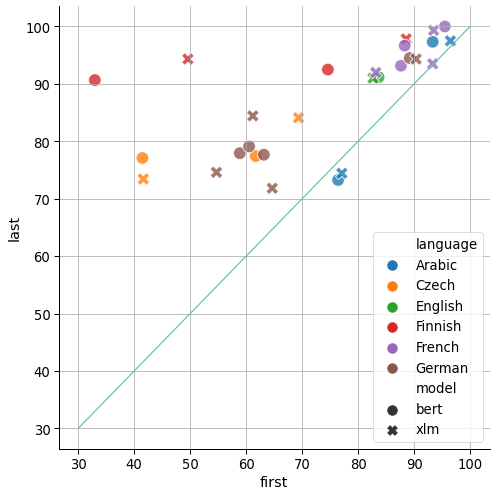

In [18]:
m = morph.copy()
m['model'] = m['model'].apply(lambda x: x.split('-')[0])
m.subword_pooling = m.subword_pooling.astype(str)
m = m[m.subword_pooling.isin(['first', 'last'])]
m['test_acc'] = (m['test_acc'] * 100).round(1)

m = m.groupby(['full_task', 'subword_pooling', 'model']).test_acc.mean().unstack(1).reset_index()
m['language'] = m.full_task.apply(lambda t: t.split(" ")[0])
m['task'] = m.full_task.apply(lambda t: t.split(" ")[1])
fig, ax = plt.subplots(1, figsize=(7, 7))
ax = sns.scatterplot(x=m['first'], y=m['last'], hue=m.language, style=m.model, palette='tab10', alpha=.8, s=160, ax=ax)
ax.legend(markerscale=2)
ax.plot((30, 100), (30, 100))
ax.grid()
plt.tight_layout()
sns.despine()
#fig.savefig("../fig/scatter_morph_first_last.pdf")
fig.savefig("../fig/scatter_morph_first_last.png", dpi=300)

In [19]:
m[m['first']>=m['last']]

subword_pooling,full_task,model,first,last,language,task
0,Arabic case_noun,bert,76.433333,73.266667,Arabic,case_noun
1,Arabic case_noun,xlm,77.100000,74.433333,Arabic,case_noun


## Difference between first and last

In [20]:
a = m.loc[(m['first'] - m['last']).sort_values().index]
a = a[(a['first']-a['last'] > 0) | (a['last'] - a['first'] > 0.2)]
a = a.loc[(a['first'] - a['last']).sort_values().index]
a = a[['language', 'task', 'model', 'first', 'last']]
a['first'] = (a['first'] * 100).round(1)
a['last'] = (a['last'] * 100).round(1)
a.model = a.model.str.upper()
a.model = a.model.str.replace('XLM', 'RoBERTa')
with open("../fig/table_morph_first_last_extreme.tex", "w") as f:
    a.to_latex(f, index=False, header=True)

## BERT vs Roberta

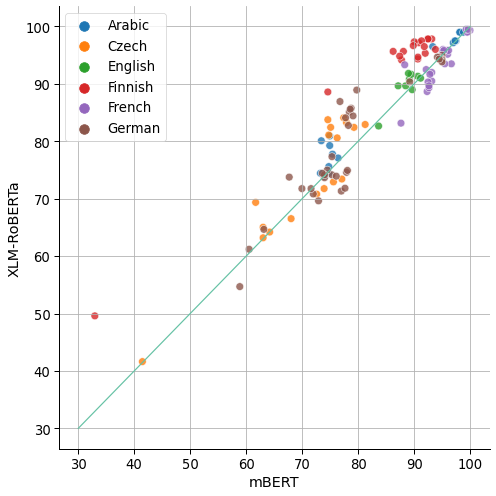

In [21]:
m = morph.copy()
m['test_acc'] = (m['test_acc'] * 100).round(1)
m = m.groupby(['full_task', 'model', 'subword_pooling']).test_acc.mean()
m = m.unstack(1).reset_index()
m['language'] = m.full_task.apply(lambda t: t.split(" ")[0])
m['task'] = m.full_task.apply(lambda t: t.split(" ")[1])

fig, ax = plt.subplots(1, figsize=(7, 7))
sns.scatterplot(x=m['bert-base-multilingual-cased'], y=m['xlm-roberta-base'],
                hue=m.language, ax=ax, palette='tab10', s=60, alpha=0.8)
ax.plot((30, 100), (30, 100))
ax.legend(markerscale=2)
ax.set_xlabel("mBERT")
ax.set_ylabel("XLM-RoBERTa")
ax.grid()
plt.tight_layout()
sns.despine()
#fig.savefig("../fig/scatter_morph_by_model.pdf")
fig.savefig("../fig/scatter_morph_by_model.png", dpi=200)

In [22]:
morph.groupby('model').test_acc.mean().round(3) * 100

model
bert-base-multilingual-cased    84.1
xlm-roberta-base                85.8
Name: test_acc, dtype: float64

In [23]:
morph.groupby(['model', 'language']).test_acc.mean().unstack(0)

model,bert-base-multilingual-cased,xlm-roberta-base
language,,
Arabic,0.860633,0.875758
Czech,0.709692,0.733002
English,0.887222,0.897407
Finnish,0.864842,0.932099
French,0.953718,0.945084
German,0.790303,0.800930


In [24]:
def get_significance_by_column(data, p=0.05):
    sign = []
    for c1 in data.columns:
        for c2 in data.columns:
            if c2 == c1:
                continue
            d = data[[c1, c2]].dropna()
            s = {
                "col1": c1,
                "col2": c2,
                "dof": len(d[c1])-1,
                f"mean1": data[c1].mean(),
                f"mean2": data[c2].mean(),
                }
            r = ttest_rel(d[c1], d[c2])
            s['p'] = r[1]
            sign.append(s)
    sign = pd.DataFrame(sign)
    sign['sign'] = sign.p < p
    return sign

## Heatmap pair

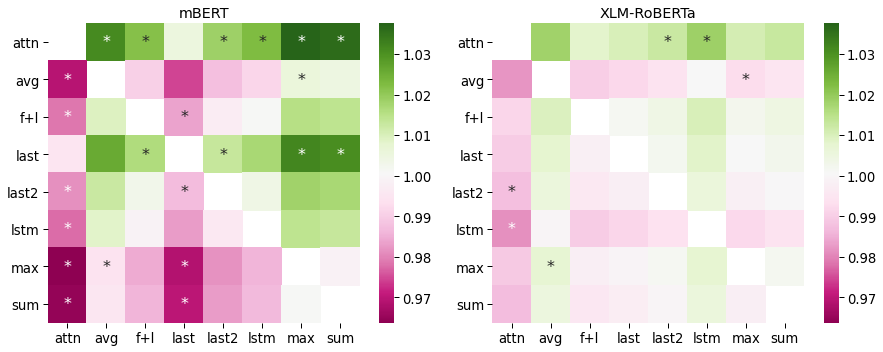

In [25]:
def plot_heatmap_pair(data, include_first=False):
    fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))

    vmin = 1
    vmax = 1

    if 'full_task' in data.columns:
        task_col = 'full_task'
    else:
        task_col = 'language'
    if include_first:
        b = data[(data.model.str.startswith('bert')==True)].copy()
    else:
        b = data[(data.model.str.startswith('bert')==True) & (data.subword_pooling!='first')].copy()
    b.subword_pooling = b.subword_pooling.astype(str)
    s = get_significance_by_column(b.groupby([task_col, 'subword_pooling']).test_acc.mean().unstack())
    s['ratio'] = s['mean1'] / s['mean2']
    vmin = min(s['ratio'].min(), vmin)
    vmax = max(s['ratio'].max(), vmax)

    annot1 = s.pivot(index='col1', columns='col2', values='sign').fillna(False).astype(str)
    annot1 = annot1.stack().replace("False", "").replace("True", "*").unstack()
    ratio1 = s.pivot(index='col1', columns='col2', values='ratio')

    if include_first:
        b = data[(data.model.str.startswith('bert')==False)].copy()
    else:
        b = data[(data.model.str.startswith('bert')==False) & (data.subword_pooling!='first')].copy()
    b.subword_pooling = b.subword_pooling.astype(str)
    s = get_significance_by_column(b.groupby([task_col, 'subword_pooling']).test_acc.mean().unstack())
    s['ratio'] = s['mean1'] / s['mean2']
    vmin = min(s['ratio'].min(), vmin)
    vmax = max(s['ratio'].max(), vmax)

    annot2 = s.pivot(index='col1', columns='col2', values='sign').fillna(False).astype(str)
    annot2 = annot2.stack().replace("False", "").replace("True", "*").unstack()
    ratio2 = s.pivot(index='col1', columns='col2', values='ratio')

    sns.heatmap(ratio1, ax=ax[0], cmap='PiYG', annot=annot1, fmt="s", linecolor='black',
                annot_kws={"fontsize": 16}, vmin=vmin, vmax=vmax)
    ax[0].set_title('mBERT')
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    ax[0].tick_params(axis='y', rotation=0)
    sns.heatmap(ratio2, ax=ax[1], cmap='PiYG', annot=annot2, fmt="s", linecolor='black',
                annot_kws={"fontsize": 16}, vmin=vmin, vmax=vmax)
    ax[1].set_title('XLM-RoBERTa')
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")
    ax[1].tick_params(axis='y', rotation=0)
    return fig, ax

fig, ax = plot_heatmap_pair(morph, include_first=False)
plt.tight_layout()
#fig.savefig("../fig/heatmap_pair_morph.pdf")
fig.savefig("../fig/heatmap_pair_morph.png", dpi=400)

# POS + NER

In [26]:
pos.groupby(['model', 'language', 'subword_pooling']).test_acc.mean().reset_index().groupby('model').mean().round(3) * 100

,test_acc
model,
bert-base-multilingual-cased,95.8
xlm-roberta-base,96.3


In [27]:
ner.groupby(['model', 'language', 'subword_pooling']).test_acc.mean().reset_index().groupby('model').mean().round(3) * 100

,test_acc
model,
bert-base-multilingual-cased,92.5
xlm-roberta-base,89.9


Which model is better?

In [28]:
pos.groupby(['model', 'language', 'subword_pooling']).test_acc.mean().unstack(0).idxmax(axis=1).value_counts()

xlm-roberta-base                65
bert-base-multilingual-cased    16
dtype: int64

In [29]:
ner.groupby(['model', 'language', 'subword_pooling']).test_acc.mean().unstack(0).idxmax(axis=1).value_counts()

bert-base-multilingual-cased    81
dtype: int64

## POS: FIRST is significantly worse than all choices except MLP

In [30]:
p = pos.groupby(['language', 'model', 'subword_pooling']).test_acc.mean().unstack()
s = get_significance_by_column(p)

def get_better_col(row):
    if row.mean1 < row.mean2:
        return row.col2
    if row.mean1 > row.mean2:
        return row.col1
    return 'same'

s['better'] = s.apply(get_better_col, axis=1)
s[s.col1=='first']

,col1,col2,dof,mean1,mean2,p,sign,better
24,first,attn,17,0.947346,0.960645,0.045343,True,attn
25,first,avg,17,0.947346,0.962684,0.016633,True,avg
26,first,f+l,17,0.947346,0.963029,0.020281,True,f+l
27,first,last,17,0.947346,0.959545,0.053347,False,last
28,first,last2,17,0.947346,0.962982,0.021622,True,last2
29,first,lstm,17,0.947346,0.964466,0.013761,True,lstm
30,first,max,17,0.947346,0.961832,0.022241,True,max
31,first,sum,17,0.947346,0.962087,0.022396,True,sum


##  NER: FIRST is significantly better than all other choices except MAX

In [31]:
p = ner.groupby(['language', 'model', 'subword_pooling']).test_acc.mean().unstack()
s = get_significance_by_column(p)
s['better'] = s.apply(get_better_col, axis=1)

s[s.col1=='first']

,col1,col2,dof,mean1,mean2,p,sign,better
24,first,attn,17,0.911755,0.909710,7.741745e-04,True,first
25,first,avg,17,0.911755,0.914698,1.848494e-04,True,avg
26,first,f+l,17,0.911755,0.914976,2.210019e-05,True,f+l
27,first,last,17,0.911755,0.907275,1.240865e-09,True,first
28,first,last2,17,0.911755,0.909947,7.824002e-03,True,first
29,first,lstm,17,0.911755,0.915610,3.796133e-04,True,lstm
30,first,max,17,0.911755,0.911922,7.149699e-01,False,max
31,first,sum,17,0.911755,0.913156,2.309122e-02,True,sum


## Heatmap pairs

We exclude Chinese, Japanese and Korean

### POS without CJK

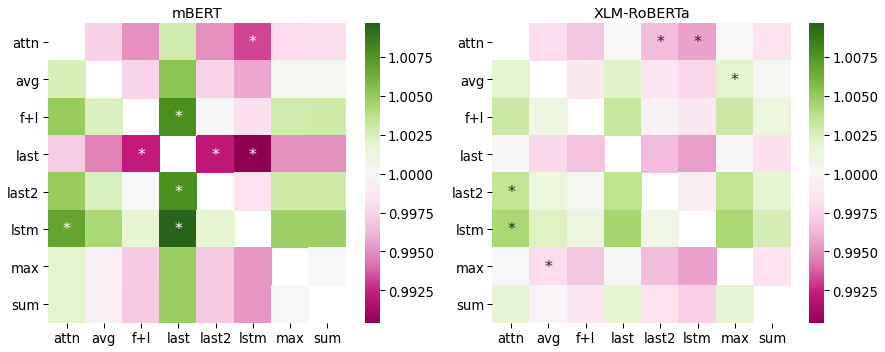

In [32]:
CJK = ('Korean', 'Chinese', 'Japanese')
pos_cjk = pos[(pos.language.isin(CJK)==True) & (pos.train_size>2000)]
fig, ax = plot_heatmap_pair(pos_cjk, include_first=False)
plt.tight_layout()
#fig.savefig("fig/heatmap_pair_pos_cjk.pdf")
fig.savefig("../fig/heatmap_pair_pos_cjk.png", dpi=200)

### POS - CJK only

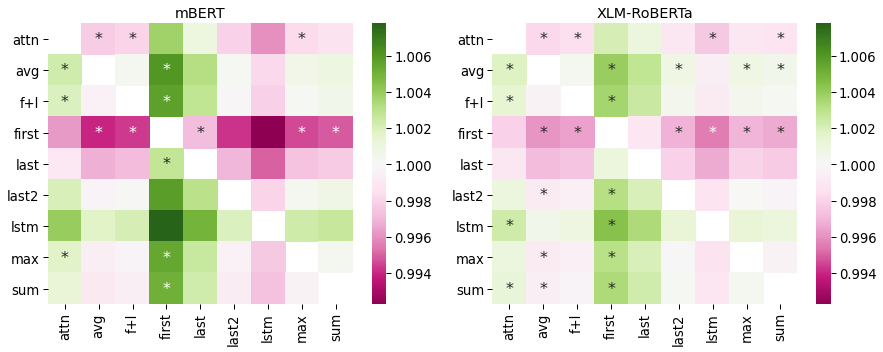

In [33]:
pos_no_cjk = pos[pos.language.isin(CJK)==False]
fig, ax = plot_heatmap_pair(pos_no_cjk, include_first=True)
plt.tight_layout()
#fig.savefig("../fig/heatmap_pair_pos_no_cjk.pdf")
fig.savefig("../fig/heatmap_pair_pos_no_cjk.png", dpi=200)

### NER without CJK

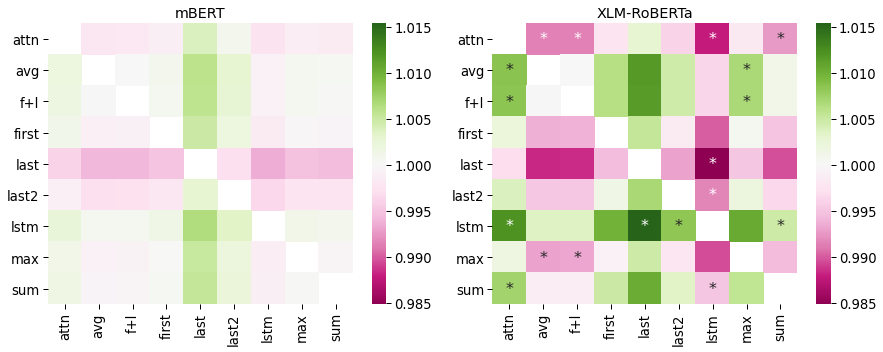

In [34]:
ner_no_cjk = ner[ner.language.isin(CJK)==True]
fig, ax = plot_heatmap_pair(ner_no_cjk, include_first=True)
plt.tight_layout()
#fig.savefig("../fig/heatmap_pair_ner_cjk.pdf")
fig.savefig("../fig/heatmap_pair_ner_cjk.png", dpi=200)

### NER - no CJK

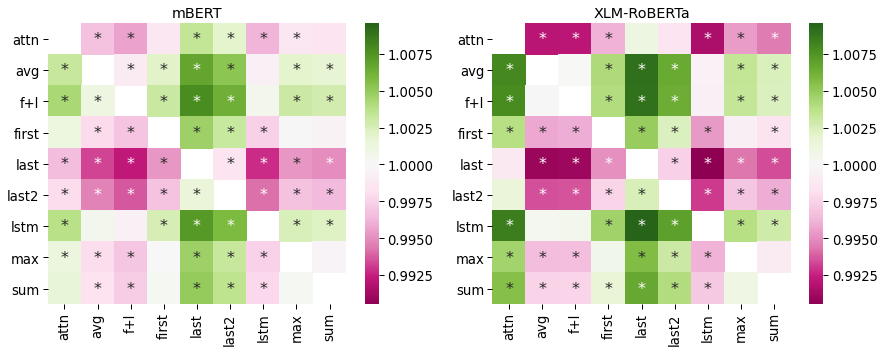

In [35]:
ner_no_cjk = ner[ner.language.isin(CJK)==False]
fig, ax = plot_heatmap_pair(ner_no_cjk, include_first=True)
plt.tight_layout()
#fig.savefig("../fig/heatmap_pair_ner_no_cjk.pdf")
fig.savefig("../fig/heatmap_pair_ner_no_cjk.png", dpi=200)

### NER - Czech, Finnish, German

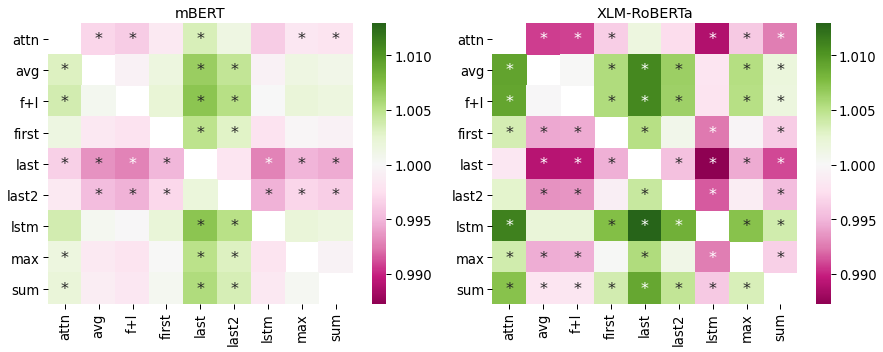

In [36]:
ner_no_cjk = ner[ner.language.isin(('Czech', 'Finnish', 'German'))==False]
fig, ax = plot_heatmap_pair(ner_no_cjk, include_first=True)
plt.tight_layout()

## BERT vs Roberta

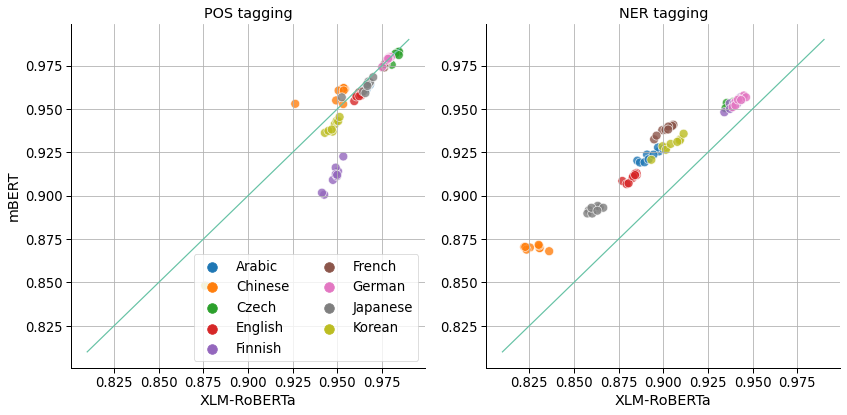

In [37]:
m = pos.groupby(['language', 'model', 'subword_pooling']).test_acc.mean()
m = m.unstack(1).reset_index()

n = ner.groupby(['language', 'model', 'subword_pooling']).test_acc.mean()
n = n.unstack(1).reset_index()

with sns.plotting_context('paper', font_scale=1.5):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.scatterplot(y=m['bert-base-multilingual-cased'], x=m['xlm-roberta-base'],
                    hue=m.language, ax=ax[0], palette='tab10', s=80, alpha=0.8)

    sns.scatterplot(y=n['bert-base-multilingual-cased'], x=n['xlm-roberta-base'],
                    legend=False,
                    hue=n.language, ax=ax[1], palette='tab10', s=80, alpha=0.8)
    axmin = 0.81
    axmax = 0.99
    ax[0].plot((axmin, axmax), (axmin, axmax))
    ax[1].plot((axmin, axmax), (axmin, axmax))
    ax[0].set_xlabel("XLM-RoBERTa")
    ax[0].set_ylabel("mBERT")
    ax[0].set_title('POS tagging')
    ax[1].set_title('NER tagging')
    ax[1].set_xlabel("XLM-RoBERTa")
    ax[1].set_ylabel("")
    ax[0].grid(True)
    ax[1].grid(True)
    ax[0].legend(markerscale=2, ncol=2, loc='lower right')
    sns.despine()

    plt.tight_layout()
    #fig.savefig("../fig/scatter_pos_by_model.pdf")
    fig.savefig("../fig/scatter_pos_by_model.png", dpi=200)

In [38]:
langcodes = {
    'Arabic': 'ar', 'Chinese': 'zh', 'Czech': 'cs', 'English': 'en', 'Finnish': 'fi', 'French': 'fr', 'German': 'de',
    'Japanese': 'jp', 'Korean': 'ko'
}

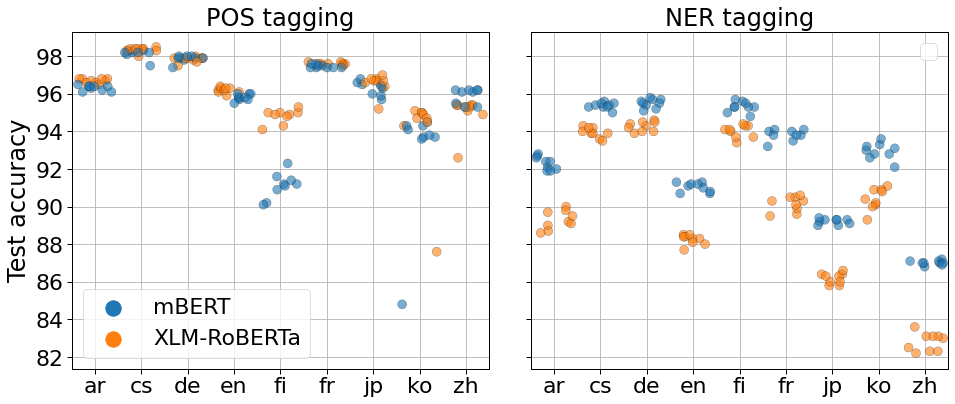

In [39]:
p = (pos.groupby(['language', 'model', 'subword_pooling']).test_acc.mean() * 100).round(1)
p = p.reset_index()
p['model'] = p['model'].replace('bert-base-multilingual-cased', 'mBERT')
p['model'] = p['model'].replace('xlm-roberta-base', 'XLM-RoBERTa')
p['language'] = p['language'].apply(lambda l: langcodes[l])
p = p.sort_values('language')

n = (ner.groupby(['language', 'model', 'subword_pooling']).test_acc.mean() * 100).round(1)
n = n.reset_index()
n['model'] = n['model'].replace('bert-base-multilingual-cased', 'mBERT')
n['model'] = n['model'].replace('xlm-roberta-base', 'XLM-RoBERTa')
n['language'] = n['language'].apply(lambda l: langcodes[l])
n = n.sort_values('language')

plot_kwargs = dict(jitter=0.4, linewidth=0.3, edgecolor='black', alpha=0.6, s=9, palette='tab10')

with sns.plotting_context('paper', font_scale=2.5):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    sns.stripplot(x=p['language'], y=p['test_acc'], hue=p['model'], ax=ax[0], **plot_kwargs)
    ax[0].grid(True)
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles=handles, labels=labels, markerscale=2)
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Test accuracy")
    ax[0].set_title("POS tagging")


    sns.stripplot(x=n['language'], y=n['test_acc'], hue=n['model'], ax=ax[1], **plot_kwargs)
    ax[1].grid(True)
    handles, labels = ax[1].get_legend_handles_labels()
    ax[1].legend([], [])
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")
    ax[1].set_title("NER tagging")
    plt.subplots_adjust(wspace=.1, bottom=0.1, right=0.95, left=0.08)
    #fig.savefig("../fig/swarm_pos_ner.pdf")
    fig.savefig("../fig/swarm_pos_ner.png", dpi=200)